<a href="https://colab.research.google.com/github/RQC-Robotics/PointClouds/blob/main/PC_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/cihanongun/Point-Cloud-Autoencoder

Cloning into 'Point-Cloud-Autoencoder'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 42 (delta 3), reused 35 (delta 2), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [ ]:
!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5' #'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.9 MB 34.4 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Unin

In [ ]:
import sys
sys.path
sys.path.append('./Point-Cloud-Autoencoder')
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', './Point-Cloud-Autoencoder']


In [ ]:
import numpy as np
import time
#!pip3 install utils
import utils
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import model
import torch.optim as optim

In [ ]:
batch_size = 32
output_folder = "output/" # folder path to save the results
save_results = False # save the results to output_folder
use_GPU = True # use GPU, False to use CPU
latent_size = 30 # bottleneck size of the Autoencoder model

In [ ]:
from Dataloaders import GetDataLoaders

#pc_array = np.load("Point-Cloud-Autoencoder/data/chair_set.npy")
pc_array = arr

print(pc_array.shape)

# load dataset from numpy array and divide 90%-10% randomly for train and test sets

train_loader, test_loader = GetDataLoaders(npArray=pc_array, batch_size=batch_size)


# Assuming all models have the same size, get the point size from the first model
point_size = len(train_loader.dataset[0])
print(point_size)

(1472, 800, 3)
800


In [ ]:
net = model.PointCloudAE(point_size,latent_size)

if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

net = net.to(device)

In [ ]:
################################################################################33

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/Robotic\ files

res.npy


In [ ]:
array = np.load("drive/MyDrive/Robotic files/res.npy", allow_pickle=True)

In [ ]:
print (array.shape)

(4000,)


In [ ]:
def cut_z (arr, z_min):
  
  for i in range (arr.shape[0]):
    z = np.array([arr[i][j][2] for j in range(arr[i].shape[0])])
    arr[i] = arr[i][z > z_min]
  return np.array(arr)

def cut_point_num (arr, point_num):
  new_arr = []
  for i in range (arr.shape[0]):
    if (arr[i].shape[0] >= point_num):
        new_arr.append(arr[i][0:point_num])
  return new_arr

In [ ]:
array = cut_z(array, -0.31)

In [ ]:
array.shape

(4000,)

In [ ]:
arr = np.array(cut_point_num(array, 800))

In [ ]:
arr.shape

(1472, 800, 3)

In [ ]:
arr.shape

(1557000,)

In [ ]:
print (array.shape)

(4000,)


In [ ]:
import plotly.graph_objects as go

def draw_pc (pc_arr):

    x = np.array([pc_arr[i][0] for i in range(pc_arr.shape[0])])
    y = np.array([pc_arr[i][1] for i in range(pc_arr.shape[0])])
    z = np.array([pc_arr[i][2] for i in range(pc_arr.shape[0])])


    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
        ))])

  
    fig.show()

In [ ]:
draw_pc(arr[10])

In [ ]:
###########################################################################################

In [ ]:
from pytorch3d.loss import chamfer_distance # chamfer distance for calculating point cloud distance

optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss, _ = chamfer_distance(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i

In [ ]:
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        data = data.to(device)
        output = net(data.permute(0,2,1))
        loss, _ = chamfer_distance(data, output)
        
    return loss.item(), output.cpu()

In [ ]:
def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/i

In [ ]:
if(save_results):
    utils.clear_folder(output_folder)

epoch 0 train loss : 0.03439656881297507 test loss : 0.03142034821212292 epoch time : 0.31602001190185547



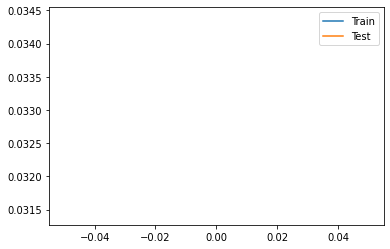

epoch 10 train loss : 0.00881846684099334 test loss : 0.01064327359199524 epoch time : 0.31777000427246094



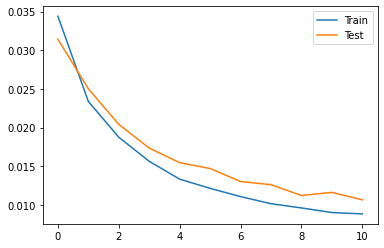

epoch 20 train loss : 0.006317966992444381 test loss : 0.00827067345380783 epoch time : 0.3116321563720703



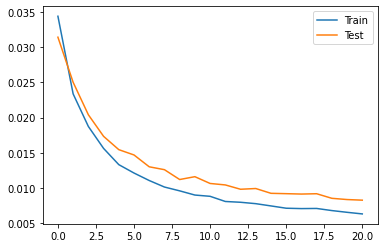

epoch 30 train loss : 0.005536101735764887 test loss : 0.0071121579967439175 epoch time : 0.3152134418487549



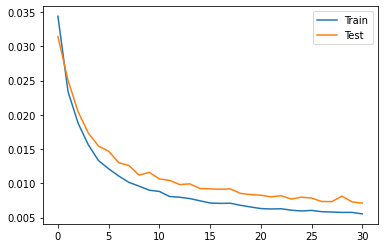

epoch 40 train loss : 0.005009105531271638 test loss : 0.0067403282737359405 epoch time : 0.3498411178588867



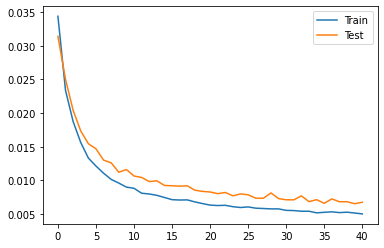

epoch 50 train loss : 0.004668149086306008 test loss : 0.0065324942115694284 epoch time : 0.30272889137268066



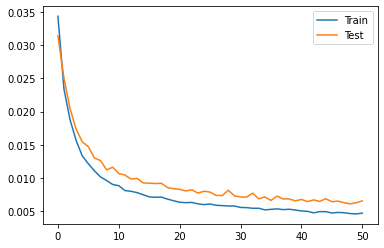

epoch 60 train loss : 0.004297686422743448 test loss : 0.00589983572717756 epoch time : 0.3258628845214844



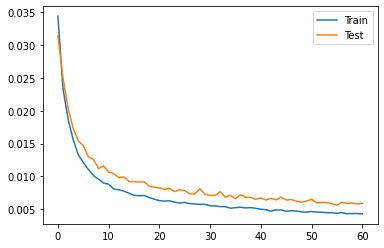

epoch 70 train loss : 0.004107740190925031 test loss : 0.005452016834169626 epoch time : 0.30864763259887695



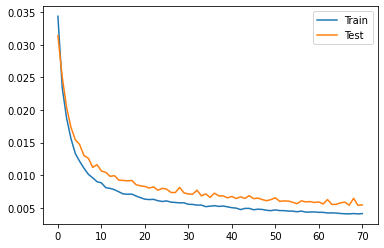

epoch 80 train loss : 0.0038980850495579766 test loss : 0.005268988781608641 epoch time : 0.3234536647796631



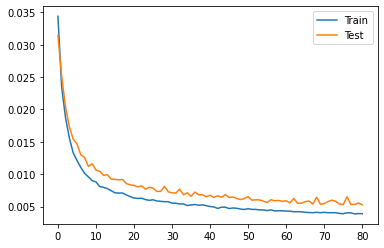

epoch 90 train loss : 0.0037120414341277465 test loss : 0.005171048978809267 epoch time : 0.31986141204833984



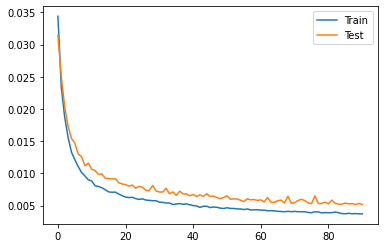

epoch 100 train loss : 0.0036834939780486064 test loss : 0.005254122312180698 epoch time : 0.3024628162384033



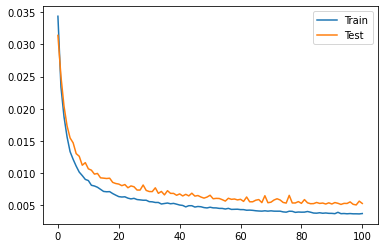

epoch 110 train loss : 0.0034229314840603167 test loss : 0.004917397513054311 epoch time : 0.3147141933441162



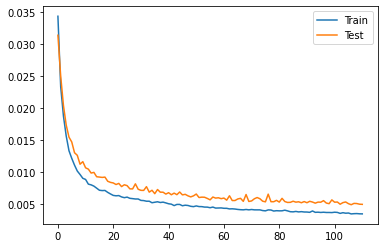

epoch 120 train loss : 0.003398327372695615 test loss : 0.00509743468137458 epoch time : 0.3326399326324463



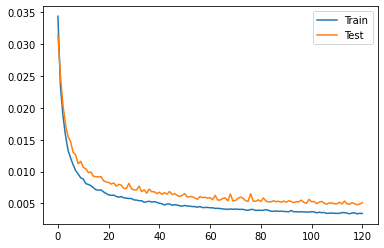

epoch 130 train loss : 0.0033421061262942668 test loss : 0.005230896640568972 epoch time : 0.3191044330596924



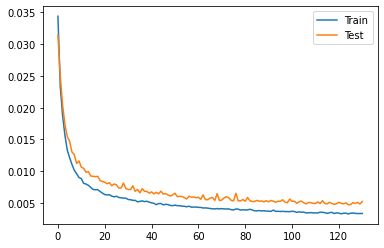

epoch 140 train loss : 0.003209555913444336 test loss : 0.004832194477785379 epoch time : 0.3306589126586914



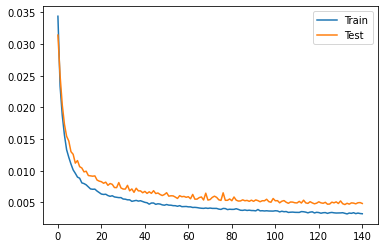

epoch 150 train loss : 0.0031284094935782798 test loss : 0.004833452170714736 epoch time : 0.30025148391723633



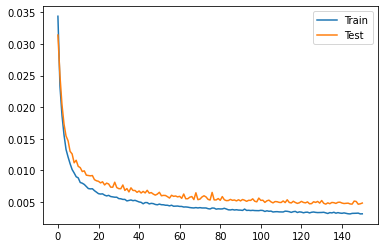

epoch 160 train loss : 0.003178861804261077 test loss : 0.0046897720312699676 epoch time : 0.34929537773132324



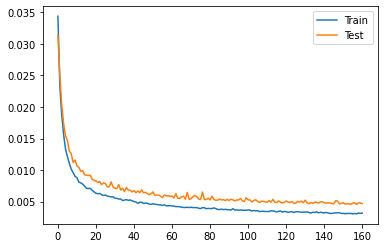

epoch 170 train loss : 0.0030470573195687882 test loss : 0.0044408050598576665 epoch time : 0.31679725646972656



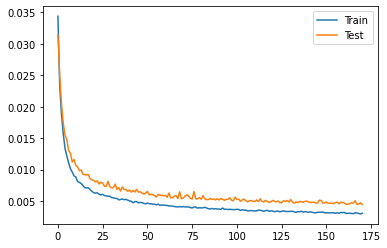

epoch 180 train loss : 0.002908358736554297 test loss : 0.004451889079064131 epoch time : 0.3121023178100586



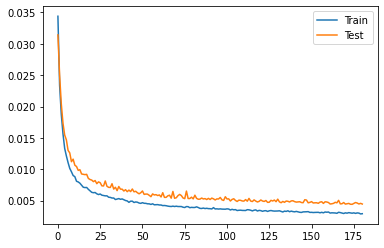

epoch 190 train loss : 0.0029238191683117936 test loss : 0.004353668249677867 epoch time : 0.32414722442626953



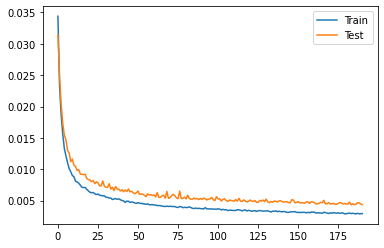

epoch 200 train loss : 0.0028626948152100894 test loss : 0.004385645792353898 epoch time : 0.3291802406311035



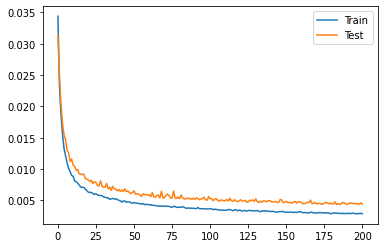

epoch 210 train loss : 0.0028669034619247767 test loss : 0.004485766228754073 epoch time : 0.366776704788208



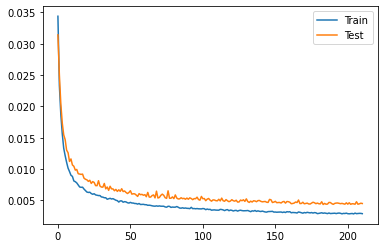

epoch 220 train loss : 0.0028464493523465426 test loss : 0.0044440822675824165 epoch time : 0.31320619583129883



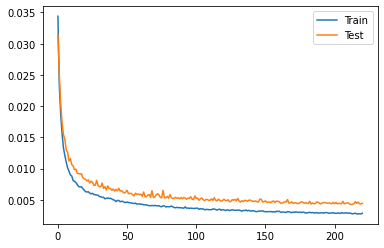

epoch 230 train loss : 0.00269846254164671 test loss : 0.004332066688220948 epoch time : 0.31923842430114746



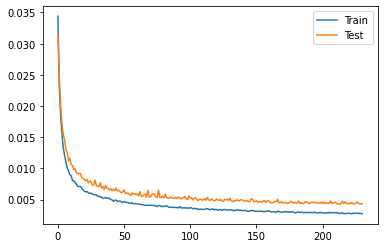

epoch 240 train loss : 0.0027238861998406852 test loss : 0.004418169031850994 epoch time : 0.2981128692626953



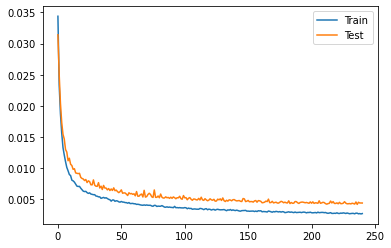

epoch 250 train loss : 0.0026201594268857706 test loss : 0.004215141816530377 epoch time : 0.31703758239746094



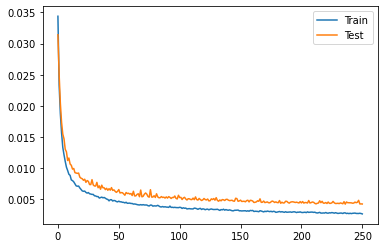

epoch 260 train loss : 0.002679443889774564 test loss : 0.004271575133316219 epoch time : 0.3154275417327881



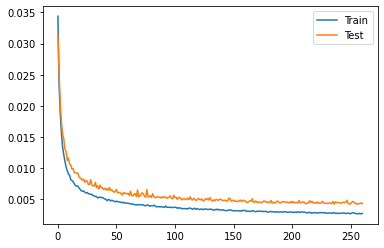

epoch 270 train loss : 0.0025823390701921974 test loss : 0.004226647724863142 epoch time : 0.3109703063964844



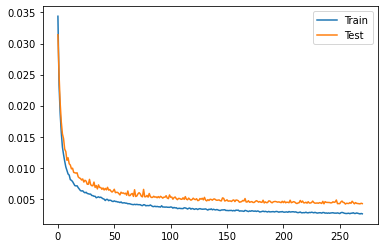

epoch 280 train loss : 0.0026927660389735202 test loss : 0.004322818596847355 epoch time : 0.31905579566955566



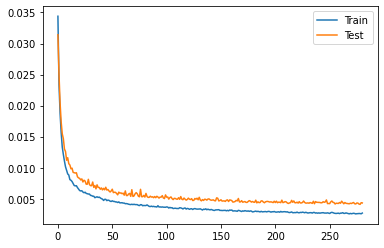

epoch 290 train loss : 0.002543751723928059 test loss : 0.004141094221267849 epoch time : 0.32826876640319824



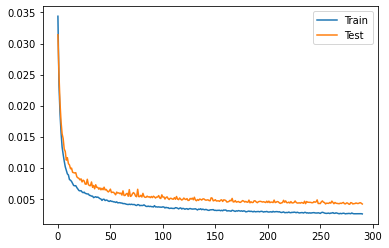

epoch 300 train loss : 0.002484605216035029 test loss : 0.004140901262871921 epoch time : 0.3078498840332031



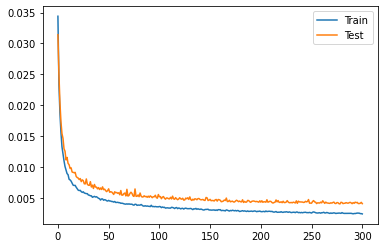

epoch 310 train loss : 0.002476258833733637 test loss : 0.004171740671154112 epoch time : 0.32021117210388184



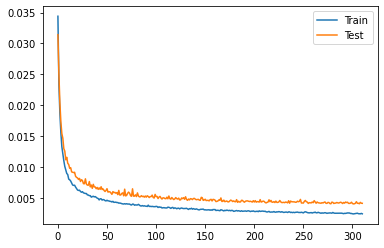

epoch 320 train loss : 0.0024946184556295234 test loss : 0.004086729430127889 epoch time : 0.33338356018066406



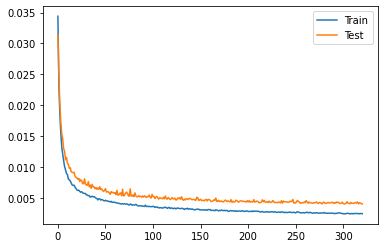

epoch 330 train loss : 0.0024696670518052286 test loss : 0.004137244075536728 epoch time : 0.3221714496612549



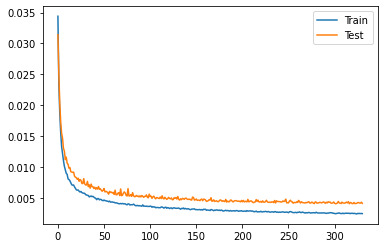

epoch 340 train loss : 0.002459332699001562 test loss : 0.004077255434822291 epoch time : 0.3158295154571533



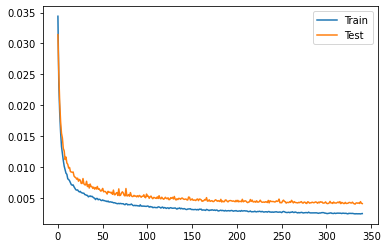

epoch 350 train loss : 0.0023949639758140575 test loss : 0.003960183181334287 epoch time : 0.32871365547180176



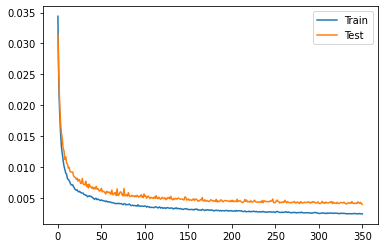

epoch 360 train loss : 0.0024075130364153443 test loss : 0.0041419604094699025 epoch time : 0.32980942726135254



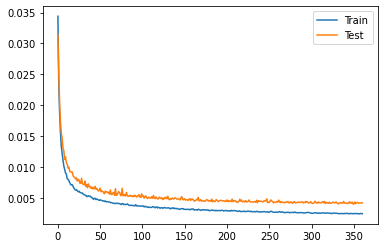

epoch 370 train loss : 0.0024775133706720137 test loss : 0.004136617470066994 epoch time : 0.3166372776031494



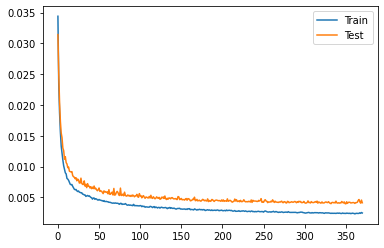

epoch 380 train loss : 0.002309446064073865 test loss : 0.0041648956830613315 epoch time : 0.31562304496765137



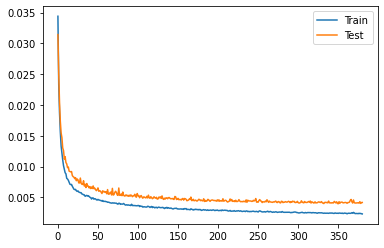

epoch 390 train loss : 0.0023718920916818626 test loss : 0.004141914192587137 epoch time : 0.31400561332702637



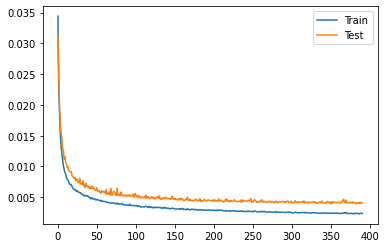

epoch 400 train loss : 0.0023117462604692798 test loss : 0.004061110434122384 epoch time : 0.33035802841186523



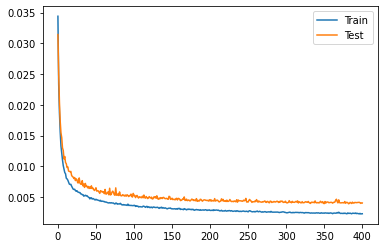

epoch 410 train loss : 0.0023432088924980744 test loss : 0.0040636518388055265 epoch time : 0.3187441825866699



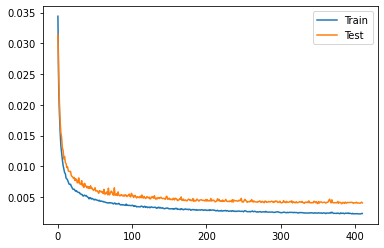

epoch 420 train loss : 0.002314871830138855 test loss : 0.004106457985471934 epoch time : 0.31426095962524414



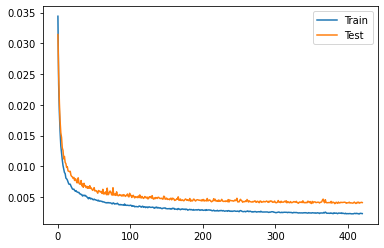

epoch 430 train loss : 0.0023340267958346663 test loss : 0.004050829913467169 epoch time : 0.3401515483856201



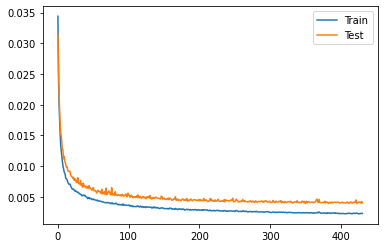

epoch 440 train loss : 0.002258884118551888 test loss : 0.004006905481219292 epoch time : 0.3227424621582031



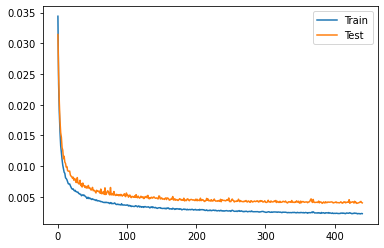

epoch 450 train loss : 0.0022821671885960714 test loss : 0.0039848159067332745 epoch time : 0.3350527286529541



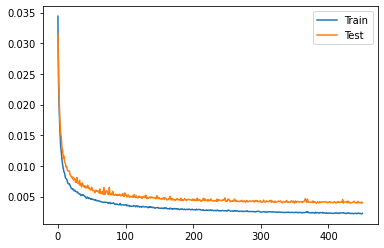

epoch 460 train loss : 0.002262776535822124 test loss : 0.004092187387868762 epoch time : 0.31101274490356445



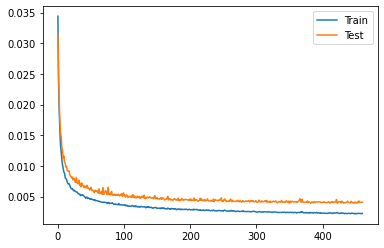

epoch 470 train loss : 0.002248964970931411 test loss : 0.004093545896466821 epoch time : 0.3139314651489258



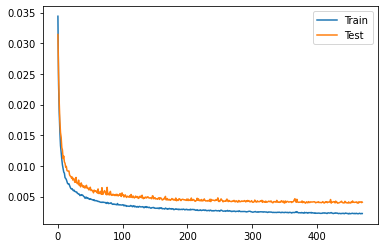

epoch 480 train loss : 0.0022113933795835914 test loss : 0.004176141519565135 epoch time : 0.31537389755249023



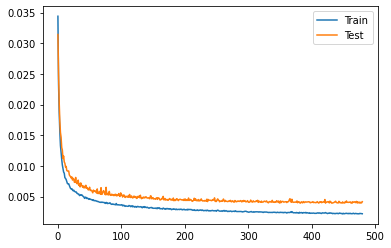

epoch 490 train loss : 0.0021781933198614816 test loss : 0.004039580235257745 epoch time : 0.3079566955566406



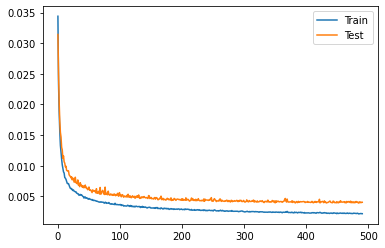

epoch 500 train loss : 0.0021704684221753624 test loss : 0.004061224986799061 epoch time : 0.33603787422180176



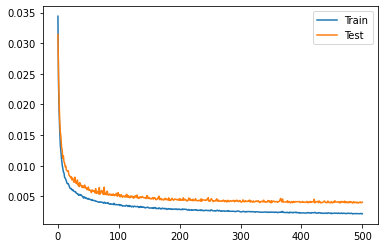

epoch 510 train loss : 0.0021918426330269475 test loss : 0.0040047685033641756 epoch time : 0.31515026092529297



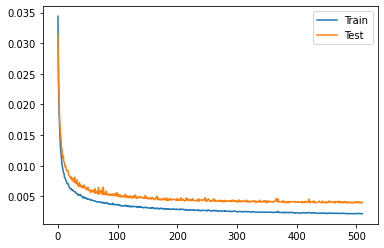

epoch 520 train loss : 0.002214693634702665 test loss : 0.003946717421058565 epoch time : 0.31928229331970215



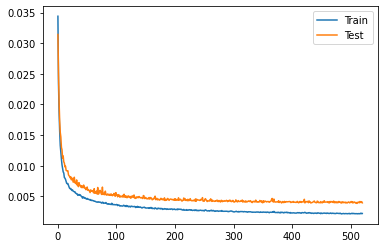

epoch 530 train loss : 0.0021478552513233408 test loss : 0.003905489982571453 epoch time : 0.32983851432800293



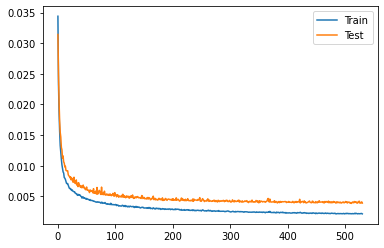

epoch 540 train loss : 0.002156967209175047 test loss : 0.003985019167885184 epoch time : 0.35531187057495117



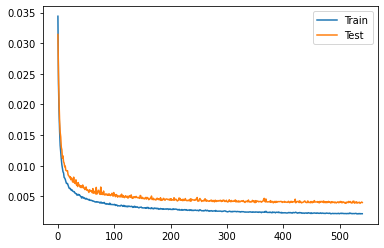

epoch 550 train loss : 0.0020643383202074866 test loss : 0.003929399768821895 epoch time : 0.32027769088745117



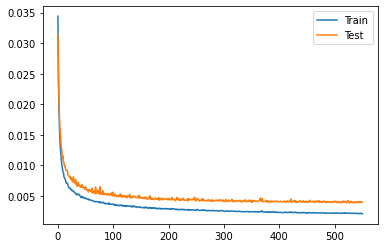

epoch 560 train loss : 0.0021422070468117187 test loss : 0.004262382281012833 epoch time : 0.3752768039703369



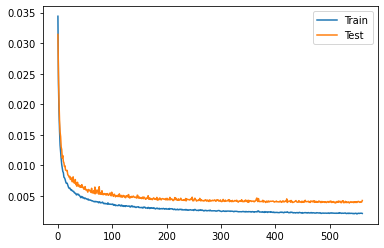

epoch 570 train loss : 0.002156787940937026 test loss : 0.004117683100048453 epoch time : 0.3100857734680176



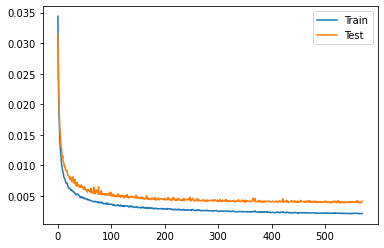

epoch 580 train loss : 0.002073713436313882 test loss : 0.0038718744181096554 epoch time : 0.329998254776001



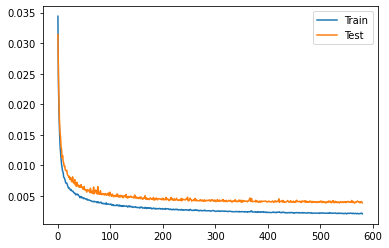

epoch 590 train loss : 0.002076011784261138 test loss : 0.004005141498055309 epoch time : 0.34265756607055664



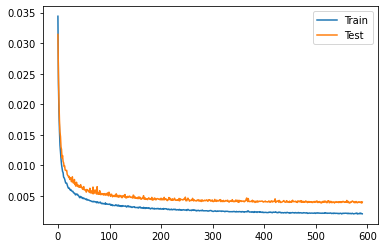

epoch 600 train loss : 0.002105535240843892 test loss : 0.003903128963429481 epoch time : 0.30751752853393555



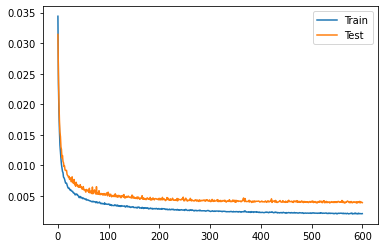

epoch 610 train loss : 0.002076851982032744 test loss : 0.0038997937226668 epoch time : 0.31770753860473633



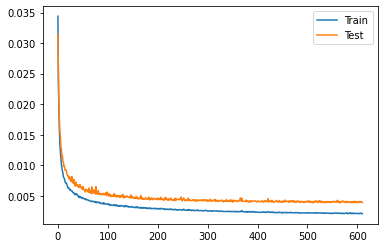

epoch 620 train loss : 0.0020631158656281667 test loss : 0.0039279459160752594 epoch time : 0.3363306522369385



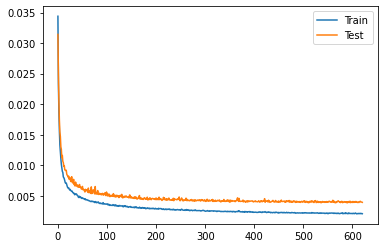

epoch 630 train loss : 0.00207966029155636 test loss : 0.003937780682463199 epoch time : 0.32946348190307617



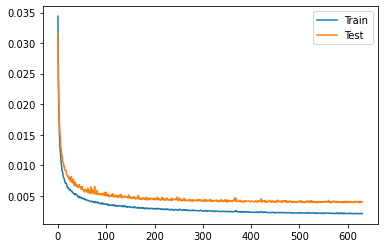

epoch 640 train loss : 0.0020290015708291677 test loss : 0.00409156468231231 epoch time : 0.31335997581481934



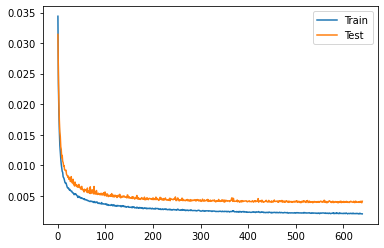

epoch 650 train loss : 0.0020667025024389348 test loss : 0.003948164754547179 epoch time : 0.31521010398864746



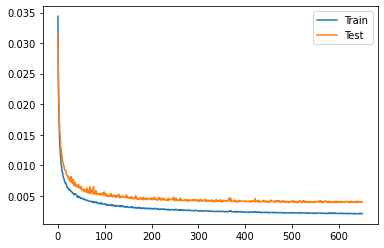

epoch 660 train loss : 0.0020571853454429204 test loss : 0.004017205093987286 epoch time : 0.32987356185913086



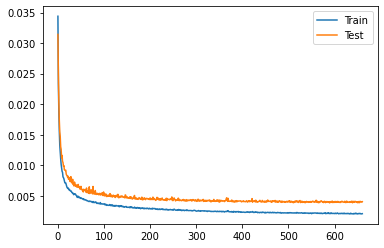

epoch 670 train loss : 0.0020660934458691174 test loss : 0.003876916307490319 epoch time : 0.3001692295074463



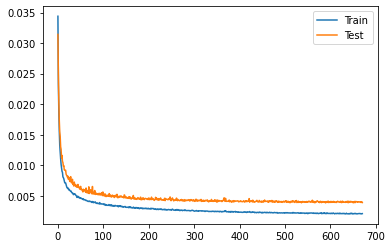

epoch 680 train loss : 0.0020429296617782335 test loss : 0.003895553876645863 epoch time : 0.33367204666137695



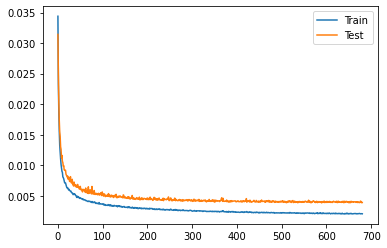

epoch 690 train loss : 0.0019720386111790815 test loss : 0.003966195974498987 epoch time : 0.3221852779388428



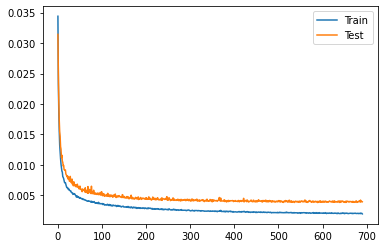

epoch 700 train loss : 0.0019744171295315027 test loss : 0.003946276905480772 epoch time : 0.33995985984802246



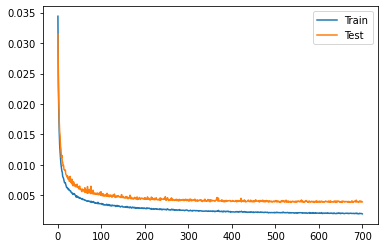

epoch 710 train loss : 0.002059722881446161 test loss : 0.00396126921987161 epoch time : 0.31948208808898926



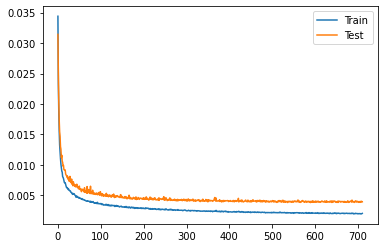

epoch 720 train loss : 0.002044134304813314 test loss : 0.003978194377850741 epoch time : 0.32987427711486816



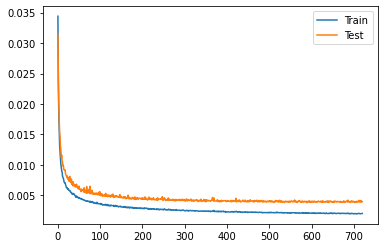

epoch 730 train loss : 0.0019978975576189595 test loss : 0.004043522349093109 epoch time : 0.313631534576416



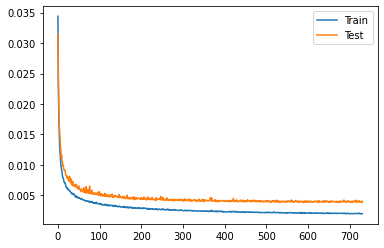

epoch 740 train loss : 0.002003686068147966 test loss : 0.003819363424554467 epoch time : 0.3364737033843994



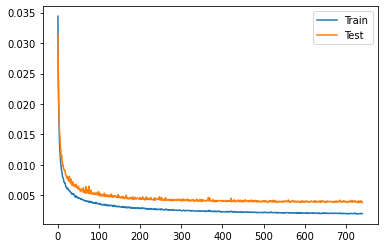

epoch 750 train loss : 0.001980244054277314 test loss : 0.003935453773010522 epoch time : 0.31433844566345215



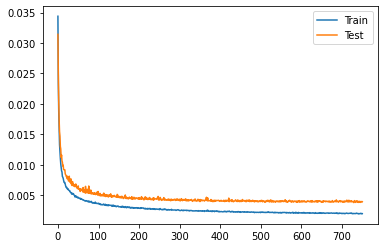

epoch 760 train loss : 0.001978591101516674 test loss : 0.003952069324441254 epoch time : 0.3287811279296875



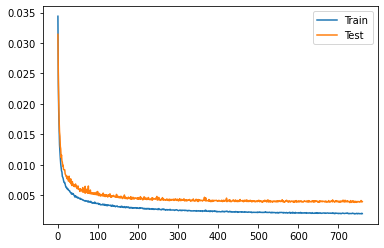

epoch 770 train loss : 0.0019754854928156953 test loss : 0.003924638032913208 epoch time : 0.32073473930358887



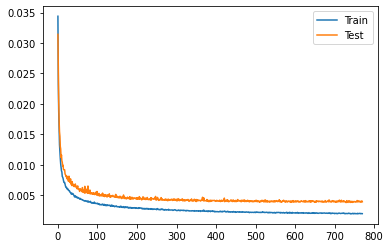

epoch 780 train loss : 0.0019888640012274065 test loss : 0.00410693627782166 epoch time : 0.31619882583618164



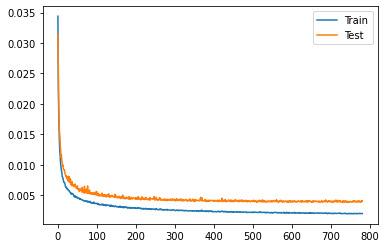

epoch 790 train loss : 0.001943764736785031 test loss : 0.004003894340712577 epoch time : 0.3196084499359131



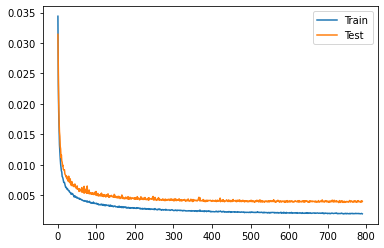

epoch 800 train loss : 0.0020132300262225835 test loss : 0.003981590911280364 epoch time : 0.3437185287475586



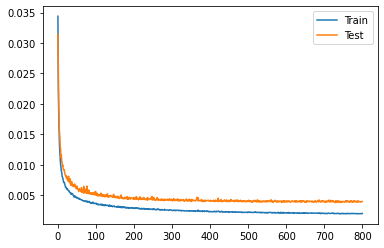

epoch 810 train loss : 0.0019433314503147835 test loss : 0.003966674557887018 epoch time : 0.3291921615600586



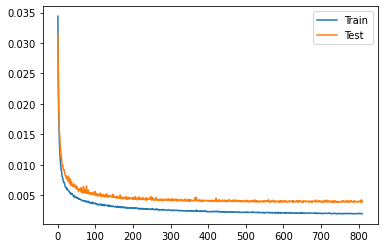

epoch 820 train loss : 0.0019843710626180214 test loss : 0.003943198011256754 epoch time : 0.31241512298583984



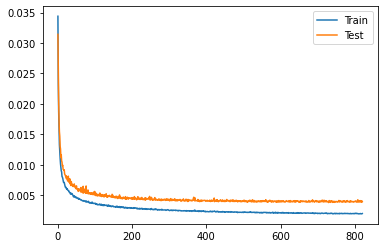

epoch 830 train loss : 0.0019758583824490993 test loss : 0.003986522380728275 epoch time : 0.3356435298919678



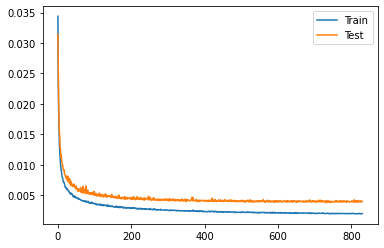

epoch 840 train loss : 0.001987427759847445 test loss : 0.003974521881900728 epoch time : 0.31938886642456055



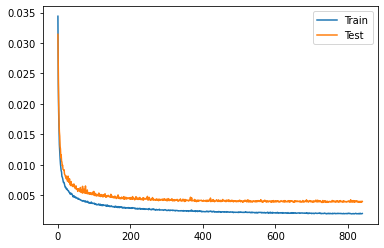

epoch 850 train loss : 0.001997153649515495 test loss : 0.0039016676018945873 epoch time : 0.3291308879852295



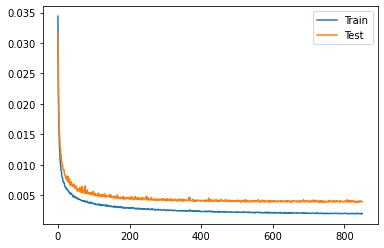

epoch 860 train loss : 0.0019506982828649442 test loss : 0.003950209298636764 epoch time : 0.3143904209136963



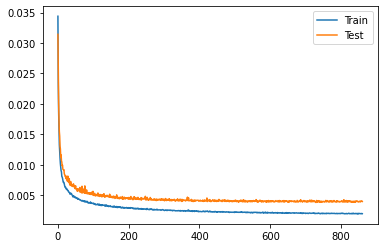

epoch 870 train loss : 0.0019344809073273365 test loss : 0.0038707968778908253 epoch time : 0.3105449676513672



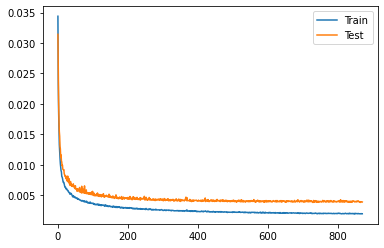

epoch 880 train loss : 0.0019014488121994386 test loss : 0.004036825615912676 epoch time : 0.3192310333251953



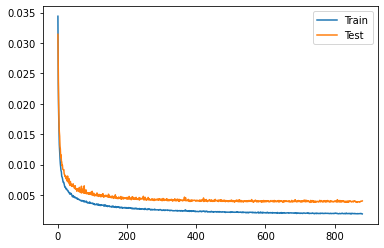

epoch 890 train loss : 0.00199805831582081 test loss : 0.004059313621837646 epoch time : 0.31731605529785156



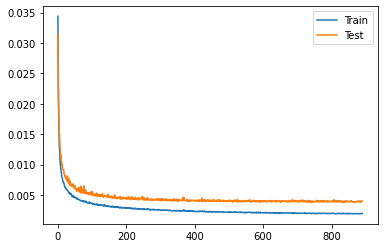

epoch 900 train loss : 0.0019765558891089224 test loss : 0.003907312406226993 epoch time : 0.3182063102722168



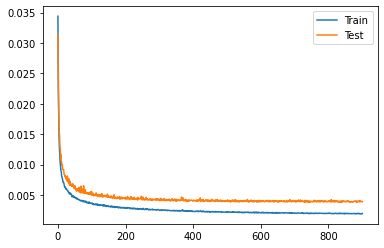

epoch 910 train loss : 0.0019059485909188303 test loss : 0.0038446514518000185 epoch time : 0.32075929641723633



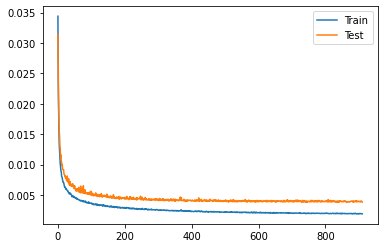

epoch 920 train loss : 0.0019158928075850737 test loss : 0.0038253440288826823 epoch time : 0.31537842750549316



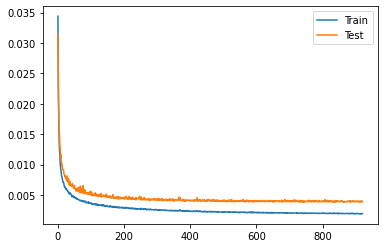

epoch 930 train loss : 0.001905883151310973 test loss : 0.003938214562367648 epoch time : 0.3144207000732422



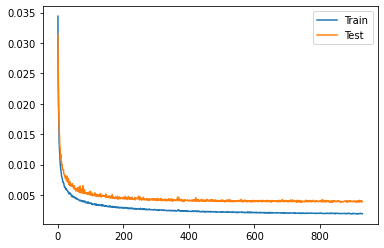

epoch 940 train loss : 0.0019027928640021057 test loss : 0.0038631887873634696 epoch time : 0.3099043369293213



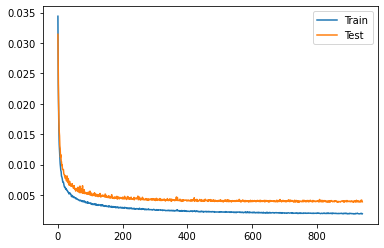

epoch 950 train loss : 0.001910892684330664 test loss : 0.003972553298808634 epoch time : 0.31407737731933594



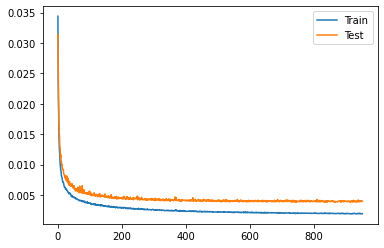

epoch 960 train loss : 0.0018921541163652409 test loss : 0.003897308837622404 epoch time : 0.3352365493774414



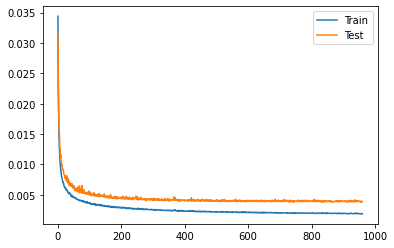

epoch 970 train loss : 0.0019145501584450647 test loss : 0.0038570448523387313 epoch time : 0.3177754878997803



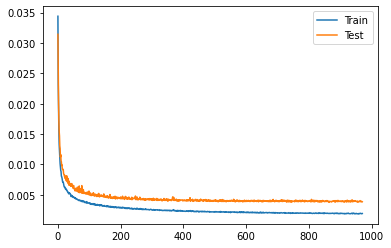

epoch 980 train loss : 0.0018743887804902907 test loss : 0.0038770756800659 epoch time : 0.31346869468688965



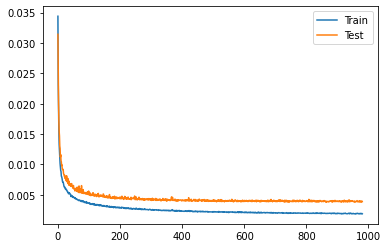

epoch 990 train loss : 0.0018899386220543486 test loss : 0.003804110689088702 epoch time : 0.3214843273162842



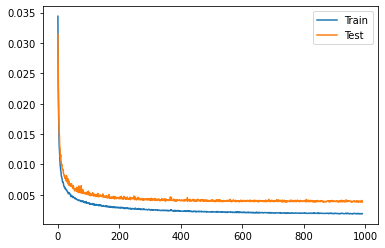

epoch 1000 train loss : 0.0018869152877525222 test loss : 0.003935625893063843 epoch time : 0.3246946334838867



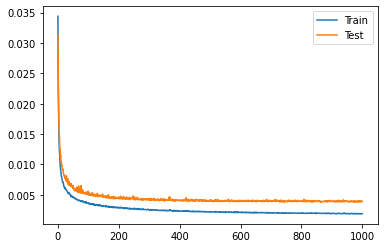

In [ ]:
train_loss_list = []  
test_loss_list = []  

for i in range(1001) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    # plot train/test loss graph
    if (i%10 == 0):
        plt.plot(train_loss_list, label="Train")
        plt.plot(test_loss_list, label="Test")
        plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i)))

    else : # display all outputs
        
        if (i%10 == 0):
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            #utils.plotPCbatch(test_samples,test_output)
            print(writeString)
            plt.show()

In [ ]:
test_samples = next(iter(test_loader))
loss , test_output = test_batch(test_samples)

In [ ]:
draw_pc(test_samples[1].detach().numpy())

In [ ]:
draw_pc(test_output[1].detach().numpy())